# TLE Determination
In this notebook, we estimate a TLE based on an OPM, or an inital state.

In [1]:
import plotly.express as px

import numpy as np

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.time import Interval
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.environment.object.celestial import Earth
from ostk.physics.environment.object.celestial import Moon
from ostk.physics.environment.object.celestial import Sun

from ostk.astrodynamics.estimator import TLESolver
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory import Propagator
from ostk.astrodynamics.trajectory.orbit.message.spacex import OPM
from ostk.astrodynamics.solver import LeastSquaresSolver
from ostk.astrodynamics.converters import coerce_to_datetime

## Setup environment
We setup an environment with Earth as the central celestial object
- EGM96 10x10
- No atmospheric drag
- Third body perturbations from the Sun and the Moon

In [2]:
environment: Environment = Environment(
    central_celestial_object=Earth.EGM96(10, 10),
    objects=[Moon.default(), Sun.default()]
)

In [3]:
tle_solver: TLESolver = TLESolver(
    solver=LeastSquaresSolver.default(),
    satellite_number=99999,
    revolution_number=1,
    estimate_b_star=False,
)

## Example from OPM
Dummy SpaceX OPM taken from [OSTk Astrodynamics tests](https://github.com/open-space-collective/open-space-toolkit-astrodynamics/blob/main/test/OpenSpaceToolkit/Astrodynamics/Trajectory/Orbit/Message/SpaceX/OPM/opm_1.yaml)

In [4]:
opm: OPM = OPM.parse("""
# Dummy SpaceX OPM output

# Notes:
# - ECEF velocity is Earth relative
# - Apogee/Perigee altitude assumes a spherical Earth, 6378.137 km radius
# - Orbital elements are computed in an inertial frame realized by inertially
#   freezing the WGS84 ECEF frame at time of current state
# - State is post-deployment, so includes separation delta-velocity


header:
  generation_date: 2020-01-01T12:34:56.789Z
  launch_date: 2020-01-02T12:34:56.789Z


deployments:

- name: satellite_a
  sequence_number: 1
  mission_time_s: 3600.0
  date: 2020-01-02T13:34:56.789Z
  r_ecef_m: [693289.644, 6876578.628, -133035.288]
  v_ecef_m_per_s: [1305.783, 39.783, 7525.920]
  mean_perigee_altitude_km: 526.768
  mean_apogee_altitude_km: 568.430
  mean_inclination_deg: 97.123
  mean_argument_of_perigee_deg: -179.513
  mean_longitude_ascending_node_deg: 85.057
  mean_mean_anomaly_deg: 179.263
  ballistic_coef_kg_per_m2: 47.55

- name: satellite_b
  sequence_number: 2
  mission_time_s: 7200.0
  date: 2020-01-02T14:34:56.789Z
  r_ecef_m: [699863.059, 6875647.517, -123777.595]
  v_ecef_m_per_s: [1504.658, 6.705, 7538.669]
  mean_perigee_altitude_km: 536.779
  mean_apogee_altitude_km: 529.851
  mean_inclination_deg: 97.124
  mean_argument_of_perigee_deg: 136.875
  mean_longitude_ascending_node_deg: 85.032
  mean_mean_anomaly_deg: -127.164
  ballistic_coef_kg_per_m2: 44.26
  """)

In [5]:
deployment: OPM.Deployment = opm.get_deployment_with_name("satellite_a")
deployment_state: State = deployment.to_state().in_frame(Frame.GCRF())

## Generate observations
- Setup a propagator based on the environment
- propagate for an interval from deployment time

In [6]:
propagator: Propagator = Propagator.default(environment=environment)

In [7]:
interval: Interval = Interval.closed(deployment.date, deployment.date + Duration.days(1.0))
instants: list[Instant] = interval.generate_grid(Duration.minutes(5.0))

In [8]:
observations: list[State] = propagator.calculate_states_at(deployment_state, instants)

## Solve
Using the first observation as an initial guess, generate a TLE analysis with an estimated TLE

In [9]:
initial_guess_state: State = observations[0]

In [10]:
analysis: TLESolver.Analysis = tle_solver.estimate(
    initial_guess=initial_guess_state,
    observations=observations,
)
print(analysis)

-- Analysis ----------------------------------------------------------------------------------------
    Estimated TLE - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    --                                      Two-Line Elements -------------------------------------------------------------------------------
    Line 1:                                  1 99999U 00001A   20002.56593506  .00000000  00000-0  00000-0 0    02 
    Line 2:                                  2 99999  96.0053  29.5295 0081092 211.9303 146.5718 15.27048789    15 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Satellite Name:                                                                   
    Satellite Number:                        99999                                    
    Classification:                          U                                        
    International Designator:                00001A           

In [11]:
residuals = analysis.solver_analysis.compute_residual_states(observations)

data = []
for residual in residuals:
    data.append(
        {
            "timestamp": coerce_to_datetime(residual.get_instant()),
            "dr [m]": np.linalg.norm(residual.get_position().get_coordinates()),
        }
    )

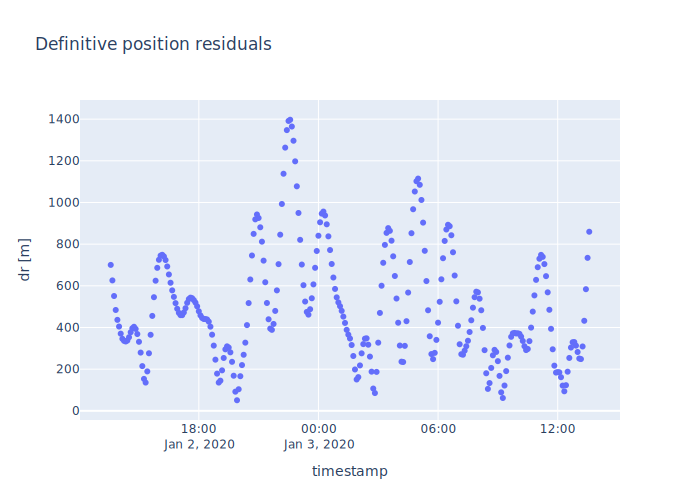

In [12]:
figure = px.scatter(data, x="timestamp", y="dr [m]", title="Definitive position residuals")
figure.show("svg")

## Solve with B* estimation
- Generate observations for a longer time interval, which is beneficial for B* estimation

In [13]:
tle_solver_with_b_star_estimation: TLESolver = TLESolver(
    solver=LeastSquaresSolver.default(),
    satellite_number=99999,
    revolution_number=1,
    estimate_b_star=True,
)

In [14]:
interval = Interval.closed(deployment.date, deployment.date + Duration.days(3.0))
instants = interval.generate_grid(Duration.minutes(5.0))

In [15]:
observations = propagator.calculate_states_at(deployment_state, instants)

We can use the previous TLE as an initial guess, or we can also provide a tuple of (State, B* guess)

In [16]:
analysis_with_b_star_estimation: TLESolver.Analysis = tle_solver_with_b_star_estimation.estimate(
    initial_guess=(observations[0], 1e-4),
    observations=observations,
)
print(analysis_with_b_star_estimation)

-- Analysis ----------------------------------------------------------------------------------------
    Estimated TLE - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    --                                      Two-Line Elements -------------------------------------------------------------------------------
    Line 1:                                  1 99999U 00001A   20002.56593506  .00000000  00000-0 -10286-5 0    05 
    Line 2:                                  2 99999  96.0054  29.5295 0081229 211.8839 146.6208 15.27046805    13 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Satellite Name:                                                                   
    Satellite Number:                        99999                                    
    Classification:                          U                                        
    International Designator:                00001A           

In [17]:
residuals = analysis_with_b_star_estimation.solver_analysis.compute_residual_states(observations)

data = []
for residual in residuals:
    data.append(
        {
            "timestamp": coerce_to_datetime(residual.get_instant()),
            "dr [m]": np.linalg.norm(residual.get_position().get_coordinates()),
        }
    )

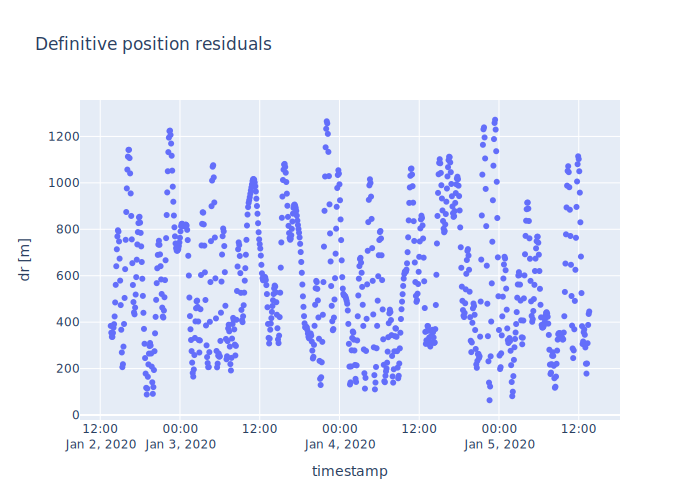

In [18]:
figure = px.scatter(data, x="timestamp", y="dr [m]", title="Definitive position residuals")
figure.show("svg")

---